TO DO: 
ADD IMPRESSION LISTS FROM TEST SET TOO

In [1]:
import pandas as pd
import numpy as np
import datetime
import time 
import os
import gc
import re
import sys
from functools import partial
from gensim.models import Word2Vec
from utils import ignore_warnings, load_data, Fprint, pshape, get_cpu_count, check_dir
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def load_train_test(nrows=None):
    usecols = ['action_type', 'impressions']
    fprint = Fprint().fprint
    fprint('Load train data')
    # train
    train = load_data('train', nrows=nrows, usecols=usecols)
    pshape(train, 'train')
    # test
    fprint('Load test data')
    test = load_data('test', nrows=nrows, usecols=usecols)
    pshape(train, 'test')

    # concat
    return pd.concat([train, test], axis=0, ignore_index=True)


def create_embeddings(nrows=None):
    fprint = Fprint().fprint
    filepath = './hotel_2vec'
    check_dir(filepath)
    filename = os.path.join(filepath, 'model.bin')
    if os.path.isfile(filename):
        fprint(f'Load the existing hotel2vec model from {filename}')
        model = Word2Vec.load(filename)
    else:
        # first load data
        fprint('Load concatenated train and test')
        tt = load_train_test(nrows=nrows)

        fprint("Select only 'clickout item' action type and impressions not na")
        # select the rows that is clickout
        is_clickout = tt['action_type'] == 'clickout item'
        del tt['action_type']
        # and the impressions are not nans
        imp_not_na = tt['impressions'].notna()
        select_mask = is_clickout & imp_not_na
        tt = tt[select_mask].reset_index(drop=True)
        # convert to list of item ids (str)
        tt['impressions'] = tt['impressions'].str.split('|')
        impressions = list(tt['impressions'].values)
        del tt
        gc.collect()

        fprint('Train word2vec embeddings')
        ncpu = get_cpu_count()
        # train model
        model = Word2Vec(impressions, min_count=1, workers=ncpu)
        fprint('Done training, saving model to disk')

        model.save(filename)
        fprint(f'Done saving hotel2vec model to {filename}')
    return model


In [3]:
model = create_embeddings()

[>>>>>] Load the existing hotel2vec model from ./hotel_2vec/model.bin


In [4]:
model.wv['7818446']

array([ 0.7774305 , -0.5147847 ,  0.89095974, -1.077152  ,  2.4707959 ,
        0.4865022 , -2.034401  , -1.2280445 , -0.071091  , -1.7163506 ,
       -1.7965375 , -0.3059116 , -1.2664864 , -0.8122727 , -0.28963372,
        0.9876559 ,  0.09538871, -0.812492  ,  0.06057218, -2.8102684 ,
        2.6119528 ,  0.87067026,  0.1710684 , -1.559535  , -2.8806546 ,
        1.2330339 ,  0.11694084,  0.1806741 ,  0.19052647, -0.7172051 ,
        0.46160394, -1.2939998 , -0.6281386 ,  0.78632396,  0.37361684,
       -0.18523356,  2.521173  , -0.65291256,  1.9783053 ,  0.1754081 ,
        1.2322241 ,  1.550463  , -0.29738414,  0.546456  , -1.9886382 ,
       -1.1397867 ,  0.09618133,  0.72791797,  0.3144678 ,  1.2258431 ,
        0.1145068 , -2.6220813 , -1.6529738 ,  0.61045665,  0.44466183,
        1.5996318 ,  0.69291806, -2.6194649 , -0.8750013 , -0.03520929,
       -0.31425992, -0.887481  ,  1.5714382 ,  0.521962  , -0.02345107,
       -0.4881012 , -0.75976783, -0.59810555,  0.8142636 ,  0.55

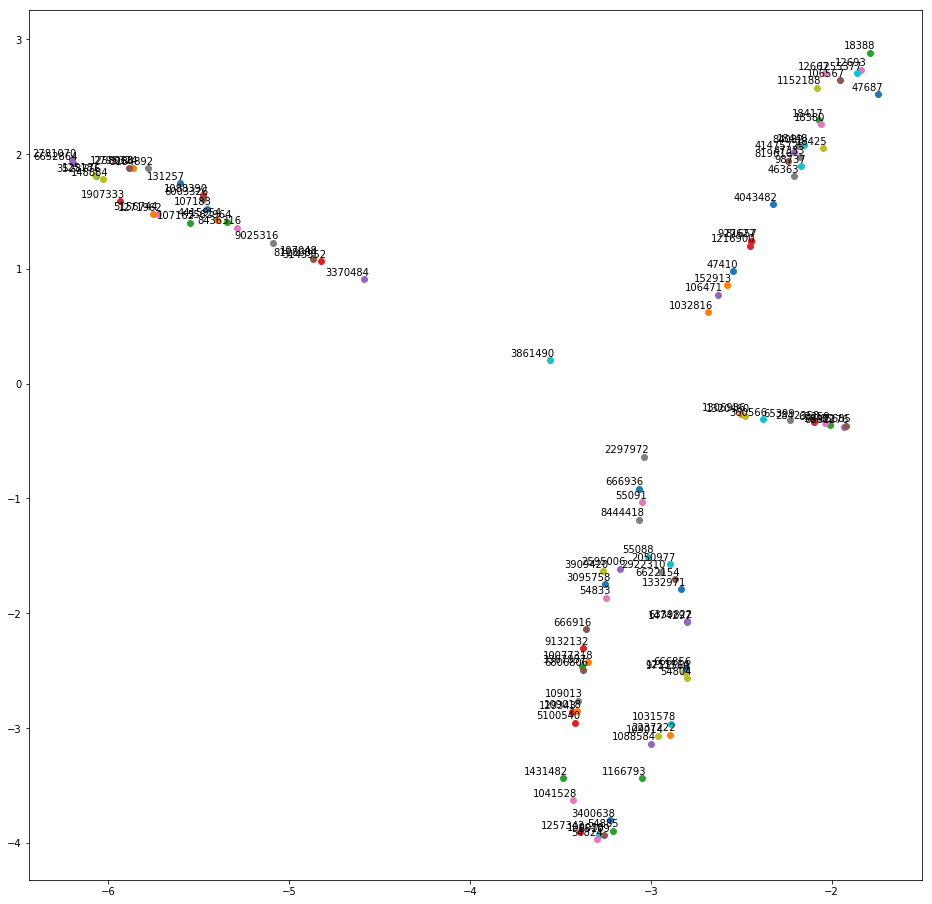

In [8]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    vocabs = list(model.wv.vocab)
    for word in vocabs[:100]:
        tokens.append(model.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=50, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
tsne_plot(model)

In [ ]:
# impressions

In [ ]:
# from gensim.models import Word2Vec
# # define training data
# sentences = [['this', 'is', 'the', 'first', 'sentence', 'for', 'word2vec'],
#              ['this', 'is', 'the', 'second', 'sentence'],
#              ['yet', 'another', 'sentence'],
#              ['one', 'more', 'sentence'],
#              ['and', 'the', 'final', 'sentence']]
# # train model
# model = Word2Vec(sentences, min_count=1)
# # summarize the loaded model
# print(model)
# # summarize vocabulary
# words = list(model.wv.vocab)
# print(words)
# # access vector for one word
# print(model['sentence'])
# # save model
# # model.save('model.bin')
# # load model
# # new_model = Word2Vec.load('model.bin')
# # print(new_model)